In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [61]:
img = Image.open("image.png").convert("RGB")
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])
img_tensor = transform(img).unsqueeze(0)

In [62]:
img.height, img.width

(512, 512)

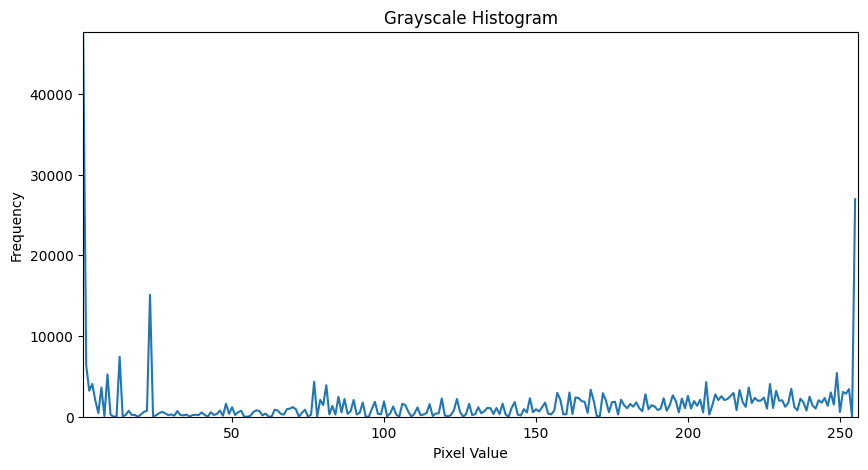

In [63]:
def histogram(image, bins=256):

    img_array = np.array(image)

    hist, bin_edges = np.histogram(img_array, bins=bins, range=(0, 256))

    plt.figure(figsize=(10, 5))
    plt.title("Grayscale Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.ylim([0, np.max(hist[1:]) + 100])
    plt.xlim([1, 256])
    plt.plot(bin_edges[0:-1], hist)
    plt.show()

histogram(img)

Epoch 8000/8000, Loss: 0.032621


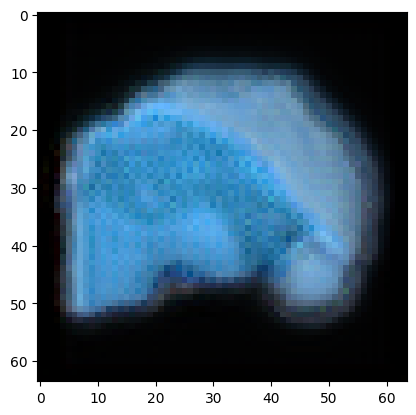

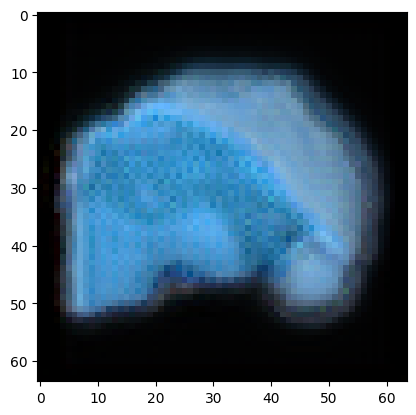

In [ ]:
class NCA(nn.Module):
    def __init__(self, channel_n=16, hidden_n=128, fire_rate=0.5):
        super().__init__()
        self.channel_n = channel_n
        self.hidden_n = hidden_n
        self.fire_rate = fire_rate

        self.perceive = nn.Conv2d(channel_n, hidden_n, kernel_size=3, padding=1)
        self.update = nn.Sequential(
            nn.Conv2d(hidden_n, hidden_n, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_n, channel_n, kernel_size=1, bias=False)
        )
        
        with torch.no_grad():
            self.update[-1].weight.zero_()

    def forward(self, x):
        y = self.perceive(x)
        y = self.update(y)

        if self.training:
            mask = (torch.rand(x.shape[0], 1, x.shape[2], x.shape[3], device=x.device) < self.fire_rate).float()
            y = y * mask

        x = x + y
        
        alive = F.max_pool2d(x[:, 3:4], kernel_size=3, stride=1, padding=1) > 0.1
        x = x * alive.float()
        
        return x
    
    def initialize(self, batch_size, height, width):
        x = torch.zeros(batch_size, self.channel_n, height, width, device=device)
        x[:, 3, height // 2, width // 2] = 1.0
        return x

from IPython.display import clear_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

nca = NCA(channel_n=16, hidden_n=128, fire_rate=0.5).to(device)
epochs = 8000
batch_size = 8

img_tensor = transform(img).unsqueeze(0).to(device)
if img_tensor.shape[1] == 3:
    alpha = torch.ones_like(img_tensor[:, 0:1])
    img_tensor = torch.cat([img_tensor, alpha], dim=1)

height, width = img_tensor.shape[2], img_tensor.shape[3]
target = img_tensor.repeat(batch_size, 1, 1, 1)

x = nca.initialize(batch_size, height, width)
optimizer = torch.optim.AdamW(nca.parameters(), lr=2e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2000, gamma=0.5)

for epoch in range(epochs):
    optimizer.zero_grad()
    
    steps = np.random.randint(64, 96)
    for _ in range(steps):
        x = nca(x)
    
    loss = F.mse_loss(x[:, 0:4], target)
    loss.backward()
    
    torch.nn.utils.clip_grad_norm_(nca.parameters(), 1.0)
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 20 == 0:
        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")
        plt.imshow(x[0, 0:3].permute(1, 2, 0).cpu().detach().clamp(0, 1).numpy())
        plt.show()
        
    with torch.no_grad():
        if epoch % 200 == 0:
             x[:2] = nca.initialize(2, height, width) 
        
        x = x.detach()

plt.imshow(x[0, 0:3].permute(1, 2, 0).cpu().detach().clamp(0, 1).numpy())
plt.show()